# Random Forest

### Install Required Libraries
Installs the imbalanced-learn library, which is required for handling class imbalance using oversampling techniques like RandomOverSampler.

In [16]:
# Install imbalanced-learn if not already installed
!pip install imbalanced-learn

You should consider upgrading via the 'C:\Users\Asus\Desktop\malis\nom\Scripts\python.exe -m pip install --upgrade pip' command.


### Import required Libraries
Handling data (numpy, os)

Visualization (matplotlib.pyplot, seaborn)

Machine learning models and preprocessing (sklearn)

Deep learning model (tensorflow.keras)

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Data paths

In [18]:
# Set the path to the dataset
base_path = "C:/Users/Asus/Desktop/malis/"
path_root = os.path.join(base_path, "DataSet Combined/")

### Data Augmentation
Configures data augmentation to artificially expand the dataset with transformations, then, loads images from the dataset directory and applies augmentations.

In [19]:
# Data Augmentation Configuration
datagen = ImageDataGenerator(
    rotation_range=30,           # Randomly rotate images up to 30 degrees
    width_shift_range=0.3,       # Randomly shift images horizontally
    height_shift_range=0.3,      # Randomly shift images vertically
    zoom_range=0.2,              # Randomly zoom into images
    horizontal_flip=True,        # Randomly flip images horizontally
    vertical_flip=True,          # Randomly flip images vertically
    brightness_range=[0.8, 1.2], # Randomly adjust brightness
    fill_mode='nearest'          # Fill missing pixels after transformation
)
# Load images and apply augmentation
batches = datagen.flow_from_directory(
    directory=path_root,         # Path to the dataset
    target_size=(256, 256),      # Resize images to 256x256
    batch_size=500               # Load 500 images at a time
)

Found 8011 images belonging to 26 classes.


### Load and Normalize Images
Loads a batch of 500 images and their labels from the dataset, then, normalizes the pixel values to a range of 0 to 1 for better model performance.

In [20]:
# Load a batch of images and their labels
imgs, labels = next(batches)
print("Image shape:", imgs.shape)  # Prints the shape of the image data
print("Labels shape:", labels.shape)  # Prints the shape of the label data

# Normalize the image pixel values to [0, 1]
imgs = imgs / 255.0


Image shape: (500, 256, 256, 3)
Labels shape: (500, 26)


### Data spliting
Splits the dataset into training (70%) and testing (30%) sets to evaluate model performance.

In [21]:
# Split the data into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(
    imgs, labels, test_size=0.3, random_state=42
)

### Feature Extraction with VGG16
Uses VGG16, pre-trained on ImageNet, to extract high-level features from the images, and
removes the classification head to focus only on feature extraction.

In [22]:
# Load the pre-trained VGG16 model (without the top classification layer)
vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

# Extract features from training and testing images
print("Extracting features ...")
vgg_features_train = vgg_model.predict(X_train)
vgg_features_test = vgg_model.predict(X_test)

Extracting features ...
11/11 ━━━━━━━━━━━━━━━━━━━━ 106s 10s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step


### Flatten and Normalize Features
Flattens the 3D feature maps into 1D arrays suitable for Random Forest, and standardizes the feature values to have zero mean and unit variance.

In [23]:
# Flatten the extracted features for Random Forest input
X_train_flat = vgg_features_train.reshape(vgg_features_train.shape[0], -1)
X_test_flat = vgg_features_test.reshape(vgg_features_test.shape[0], -1)

# Standardize the features
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_test_flat = scaler.transform(X_test_flat)

### Handle Class Imbalance
Balances the training data by oversampling the minority classes, and converts y_train from one-hot encoding to class labels for compatibility with RandomOverSampler.

In [24]:
# Balance the dataset using Random Oversampling
ros = RandomOverSampler(random_state=42)
X_train_flat, y_train = ros.fit_resample(X_train_flat, np.argmax(y_train, axis=1))

c:\Users\Asus\Desktop\malis\nom\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Asus\Desktop\malis\nom\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\Asus\Desktop\malis\nom\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


### Hyperparameter Tuning and Model Training
Defines a grid of hyperparameters for the Random Forest and performs grid search with 3-fold cross-validation to find the best combination of hyperparameters.

In [25]:
# Define hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight="balanced"),
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',  # Use accuracy as the evaluation metric
    n_jobs=-1  # Use all available CPU cores
)
print("Training Random Forest ...")
grid_search.fit(X_train_flat, y_train)

# Get the best model from grid search
best_rf_model = grid_search.best_estimator_

Training Random Forest ...


### Model Evaluation
Predicts the class labels for the test set, evaluates the model using accuracy and confusion matrix to finally visualizes the confusion matrix.

Random Forest Accuracy: 0.5266666666666666


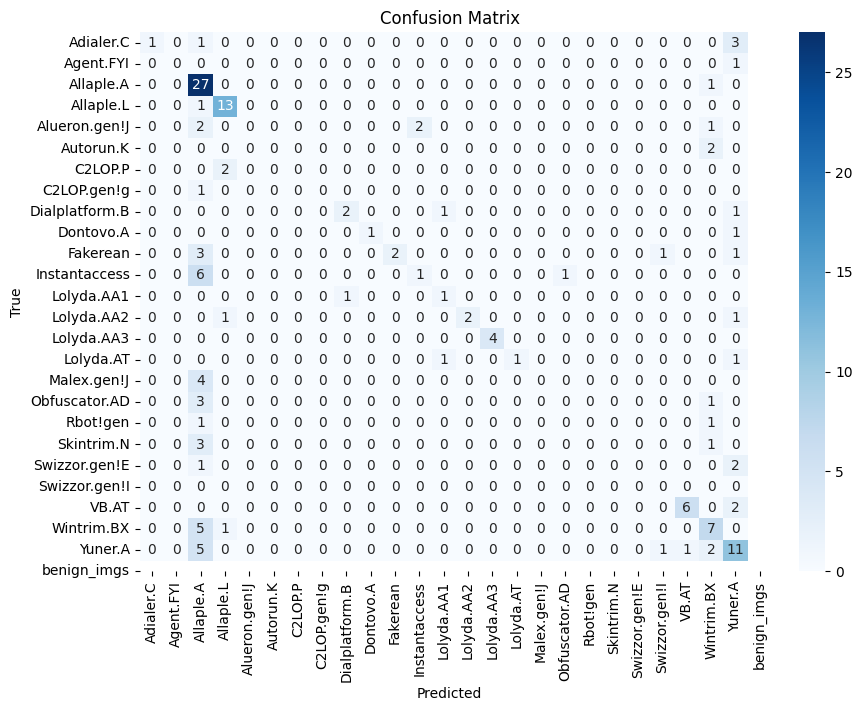

In [26]:
# Predict on the test set
y_pred = best_rf_model.predict(X_test_flat)

# Evaluate the model
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
print("Random Forest Accuracy:", accuracy)

# Confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
class_names = list(batches.class_indices.keys())
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()